<a href="https://colab.research.google.com/github/johanhoffman/DD2363_VT24/blob/ivan-private-Lab2/Lab2/ivan-private_lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Lab 2: Iterative methods**
**Ivan Zivkovic** 

# **Abstract**

This lab will show how to implement three functions:
1. Jacobi iteration
2. Gauss-Seidel iteration
3. Newton's method for scalar nonlinear equations

# **About the code**

This report is written by Ivan Zivkovic (ivanzi@kth.se)

In [198]:
"""This program is a template for lab reports in the course"""
"""DD2363 Methods in Scientific Computing, """
"""KTH Royal Institute of Technology, Stockholm, Sweden."""

# Copyright (C) 2020 Johan Hoffman (jhoffman@kth.se)

# This file is part of the course DD2365 Advanced Computation in Fluid Mechanics
# KTH Royal Institute of Technology, Stockholm, Sweden
#
# This is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This template is maintained by Johan Hoffman
# Please report problems to jhoffman@kth.se

'KTH Royal Institute of Technology, Stockholm, Sweden.'

# **Set up environment**

In [199]:
# Load neccessary modules.
#from google.colab import files

import numpy as np

from matplotlib import pyplot as plt

from IPython.core.display import Latex

from typing import TypeAlias, Callable
T_NumpyVector: TypeAlias = np.ndarray
T_NumpyMatrix: TypeAlias = np.ndarray

# **Introduction**

When solving linear equations of the form $Ax=b$ it might be too computationally expensive to try to solve it by calculating the inverse of $A$ to obtain the answer $x = A^{-1}b$. Another way of approximating $x$ is by using iterative methods. One base method for iteratively approximating $x$ is the fixed point iteration. Fixed point iteration can be described as
$$x^{(k+1)} = g(x^{(k)})$$

If $g$ is a linear operator, the so called stationary iterative method is formulated as
$$x^{(k+1)} = M x^{(k)} + c$$

For solving a system of linear equations $Ax = b$, we can use the Richardson iteration which is a stationary iterative method with $M = I - \alpha A$ and $c = \alpha b$
$$x^{(k+1)} = (I - \alpha A) x^{(k)} + \alpha b$$

To make the Richardson iteration converge to an answer faster, different type of preconditioners could be applied. Two such preconditioners are the Jacobi and Gauss-Seidel preconditioners, or Jacobi and Gauss-Seidel iteration which will be implemented in this lab. 

Furthermore, Newton's method for scalar functions will also be implemented in this lab as an iterative method to find an $x$ that satisfies $f(x) = 0$. 


# **Method**

## **Jacobi iteration for $Ax=b$**

Jacobi iteration is a type of stationary iterative method for solving the linear system of equations $Ax = b$. Stationary iterative methods can be described as a linear fixed point iteration of the form $x^{(k+1)} = M x^{(k)} + c$. 

The method for the Jacobi iteration is to split the matrix $A$ into two matrices such that $A = A_1 + A_2$, specifically: 
$$A_1 = D, \; A_2 = A-D$$
where $D$ is the diagonal of $A$, $D = diag(A)$. This gives the iteration matrix: 

$$M_J = -D^{-1} (A-D) = (I - D^{-1} A)$$
and the vector:
$$c = D^{-1} b$$

The convergence criterion for Jacobi iteration is $||I - D^{-1} A|| < 1$. 

The Jacobi iteration can further be described as: 
$$x_i^{(k+1)} = a_{ii}^{-1} ( b_i - \sum_{j \neq i} a_{ij} x_j^{(k)} ), \; \forall i$$

The convergence criterion for this algorithm will be a parameter to the function so that the user may specify at which tolerance the algorithm will return: 
$$\frac{||r^{(k)}||}{||b||}> TOL$$

In [200]:
def jacobi_iteration(A: T_NumpyMatrix, b: T_NumpyVector, x0: T_NumpyVector, max_iterations = 10**6, TOL = 1e-9) -> T_NumpyVector:
    
    n = max(b.shape)
    
    x = x0

    next_x = x
    
    r = b - A @ x

    b_norm = np.linalg.norm(b)
    
    for iteration in range(max_iterations):
        if np.linalg.norm(r) / b_norm < TOL:
            break
        
        for i in range(n):
            next_x[i] = b[i]
            for j in range(n):
                if i != j:
                    next_x[i] -= A[i, j] * x[j]
                    
            next_x[i] = next_x[i] / A[i, i] 
                 
        x = next_x
        r = b - A @ x
        
    return x


## **Gauss-Seidel iteration for $Ax=b$**

Gauss-Seidel iteration is another type of matrix splitting based stationary iterative method, much like the Jacobi iteration. The difference here is how you split the matrix $A = A_1 + A_2$:
$$A_1 = L, \; A_2 = A - L$$
where $L$ is the lower triangular matrix when you zero out all elements above the diagonal in matrix $A$. 

This gives the iteration matrix:
$$M_{GS} = -L^{-1} (A - L) = (I - L^{-1} A)$$
and the vector:
$$c = L^{-1} b$$

The triangular matrix $L$ can be inverted by forward substitution so the Gauss-Seidel iteration can be described as follows:
$$x_i^{(k+1)} = a_{ii}^{-1} ( b_i - \sum_{j < i} a_{ij} x_j^{(k+1)} - \sum_{j > i} a_{ij} x_j^{(k)} ), \; \forall i$$

In [201]:
def gauss_seidel_iteration(A: T_NumpyMatrix, b: T_NumpyVector, x0:T_NumpyVector, max_iterations = 10**6, TOL = 1e-9) -> T_NumpyVector:
    
    n = max(b.shape)
    
    x = x0

    next_x = x
    
    r = b - A @ x

    b_norm = np.linalg.norm(b)
    
    for iteration in range(max_iterations):
        if np.linalg.norm(r) / b_norm < TOL:
            break
        
        for i in range(n):
            next_x[i] = b[i]
            for j in range(i):
                next_x[i] -= A[i, j] * next_x[j]
            
            for j in range(i+1, n):
                next_x[i] -= A[i, j] * x[j]
                    
            next_x[i] = next_x[i] / A[i, i] 
                 
        x = next_x
        r = b - A @ x
        
    return x

## **Newton's method for scalar nonlinear equation $f(x)=0$**

Newton's method is an iterative method for finding a root of a function $f(x) = 0$. The method starts with an initial guess for the root of a given function and then refines that guess through a series of iterations. At each iteration, the method uses the function's value and its derivative at the current guess to update the guess for a more accurate approximation of the root. The iterative formula is:
$$x^{(k+1)} = x^{(k)} - \frac{f(x^{(k)})} {f^\prime(x^{(k)})}$$

Newton's method converges rapidly when the initial guess is close to the actual root. However, it may not always converge or may converge to a local minimum or maximum if the conditions are not met.

In [202]:
def derivative(f, x, h = 10**-6):
    return (f(x + h) - f(x)) / h

def newton_method_scalar_function(f: Callable[[float], float], x0 = 0, max_iterations = 10**6, TOL = 1e-9) -> float:
    x = x0
    
    for iteration in range(max_iterations):
        f_x = f(x)
        if np.abs(f_x) < TOL:
            break
            
        df = derivative(f, x)
        x = x - f_x / df
    
    return x

# **Results**

## **Jacobi iteration for $Ax=b$**

To test if the Jacobi iteration finds a good approximate solution for $Ax = b$, we will look at two different testcases.
1. The convergence of the residual $||Ax-b||$
2. The convergence of the residual $||x-y||$, where $y$ is a manufactured solution such that $b = Ay$ for the equation $Ax = b$

Furthermore, since the convergence criterion is $||I - D^{-1}A|| < 1$ for Jacobi iteration, the matrix $A$ in this testcase will be guaranteed to meet this convergence criterion. 

The way the convergence is tested is by running the implementation for Jacobi iteration with increasing number of max iterations.  


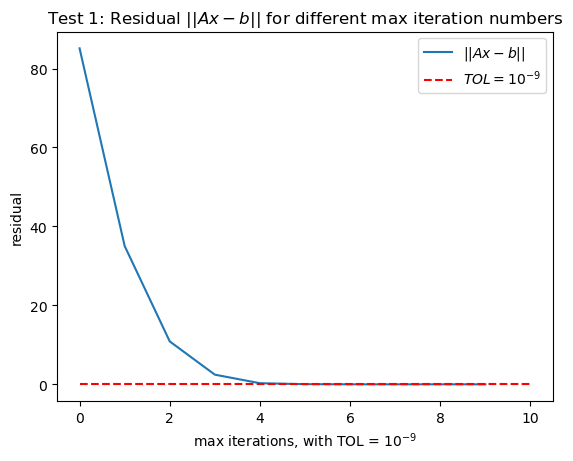

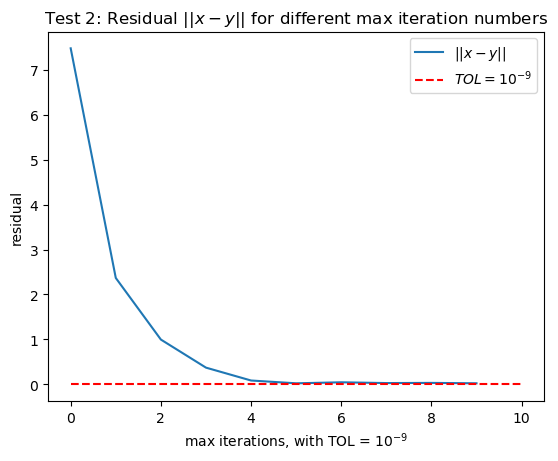

In [203]:
n = 100
A = np.random.random(size=(n,n))
b = np.random.random(size=(n, ))
x0 = np.random.random(size=(n, ))
I = np.identity(n)


A = A + 10 * I # Makes A diagonally dominant and it will meet the convergence criterion

test_iterations = 10
data = (np.zeros((test_iterations,)), np.zeros((test_iterations,)))

# Test 1
for i in range(test_iterations):
    x = jacobi_iteration(A, b, x0, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.linalg.norm((A @ x) - b)


plt.plot(data[0], data[1], label="$||Ax - b||$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 1: Residual $||Ax - b||$ for different max iteration numbers")
plt.legend()

plt.show()



# Test 2
for i in range(test_iterations):
    y = np.random.random(size=n)
    b = A @ y
    x = jacobi_iteration(A, b, x0, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.linalg.norm(x - y)


plt.plot(data[0], data[1], label="$||x-y||$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 2: Residual $||x-y||$ for different max iteration numbers")
plt.legend()

plt.show()

## **Gauss-Seidel iteration for $Ax=b$**

To test if the Gauss-Seidel iteration finds a good approximate solution for $Ax = b$, we will look at two different testcases, the same as for the Jacobi iteration.
1. The convergence of the residual $||Ax-b||$
2. The convergence of the residual $||x-y||$, where $y$ is a manufactured solution such that $b = Ay$ for the equation $Ax = b$

Furthermore, since the convergence criterion is $||I - L^{-1}A|| < 1$ for Gauss-Seidel iteration, the matrix $A$ in this testcase will be guaranteed to meet this convergence criterion. 

The way the convergence is tested is by running the implementation for Gauss-Seidel iteration with increasing number of max iterations.

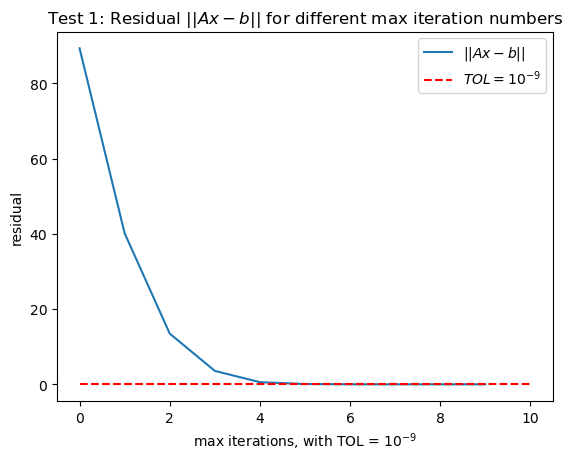

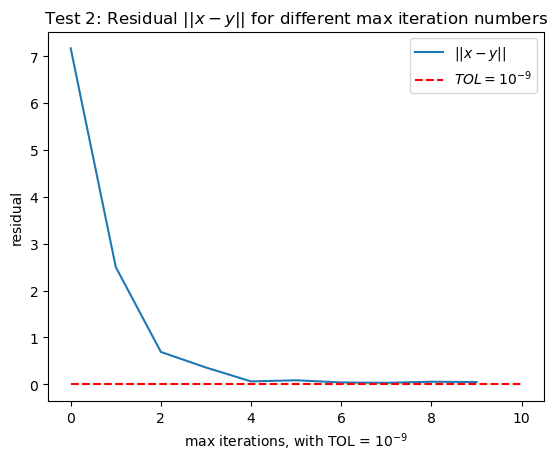

In [204]:
n = 100
A = np.random.random(size=(n,n))
b = np.random.random(size=(n, ))
x0 = np.random.random(size=(n, ))
I = np.identity(n)

A = A + 10 * I # Makes A diagonally dominant and it will meet the convergence criterion

test_iterations = 10
data = (np.zeros((test_iterations,)), np.zeros((test_iterations,)))

# Test 1
for i in range(test_iterations):
    x = gauss_seidel_iteration(A, b, x0, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.linalg.norm((A @ x) - b)


plt.plot(data[0], data[1], label="$||Ax - b||$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 1: Residual $||Ax - b||$ for different max iteration numbers")
plt.legend()

plt.show()



# Test 2
for i in range(test_iterations):
    y = np.random.random(size=n)
    b = A @ y
    x = gauss_seidel_iteration(A, b, x0, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.linalg.norm(x - y)


plt.plot(data[0], data[1], label="$||x-y||$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 2: Residual $||x-y||$ for different max iteration numbers")
plt.legend()

plt.show()

## **Newton's method for scalar nonlinear equation $f(x)=0$**

To test if Newton's method finds a good approximate root for $f(x) = 0$, we will look at two different testcases
1. The convergence of the residual $|f(x)|$
2. The convergence of the residual $|x-y|$, where $y$ is a manufactured solution such that $f(y) = 0$ 

The way the convergence is tested is by running the implementation for Newton's method with increasing number of max iterations.  


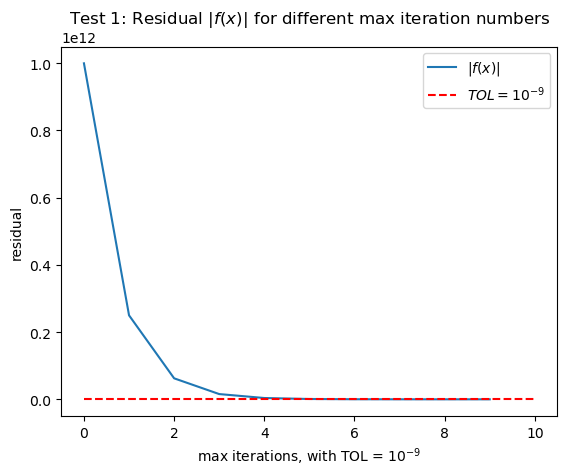

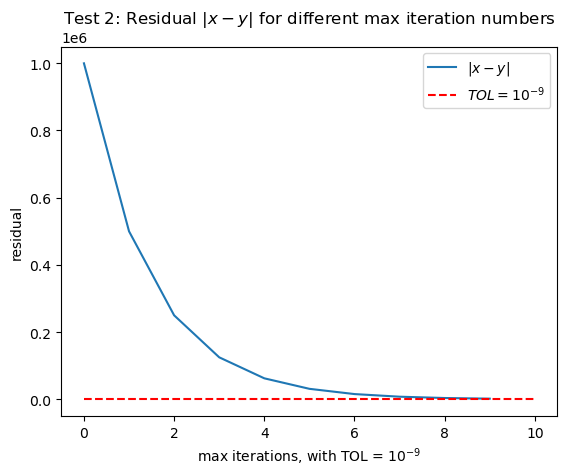

In [205]:
f = lambda x: (x-1) * (x+1)
y = 1 # exact root, f(y) = 0

test_iterations = 10
data = (np.zeros((test_iterations,)), np.zeros((test_iterations,)))

# Test 1
for i in range(test_iterations):
    x = newton_method_scalar_function(f, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.abs(f(x))

plt.plot(data[0], data[1], label="$|f(x)|$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 1: Residual $|f(x)|$ for different max iteration numbers")
plt.legend()

plt.show()



# Test 2
for i in range(test_iterations):
    x = newton_method_scalar_function(f, max_iterations=i+1)
    data[0][i] = i
    data[1][i] = np.abs(x-y)

plt.plot(data[0], data[1], label="$|x-y|$")
plt.hlines(1e-9, 0, test_iterations, colors="red", linestyles="--", label="$TOL = 10^{-9}$")
plt.xlabel("max iterations, with TOL = $10^{-9}$")
plt.ylabel("residual")
plt.title("Test 2: Residual $|x-y|$ for different max iteration numbers")
plt.legend()

plt.show()

# **Discussion**

As seen by the results, the iterative methods are converging to the actual answer for all the iterative methods. In most cases the methods are converging to an acceptable approximation after only a few iterations showing potential for being much faster than direct methods with a potentially higher residual error. To verify if this is the case the iterative methods should be compared with the direct methods to be able to reach any meaningful conclusion. 